# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import pandas as pd
from sqlalchemy import create_engine
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import re
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [2]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BOluga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\BOluga\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
# load data from database

def load_data():
    engine = create_engine('sqlite:///data/DisasterResponse.db')
    sql = 'SELECT * from messages_and_categories;'
    df = pd.read_sql(sql, engine)
    
    X = df['message']
    y = df[['related', 'request', 'offer',
       'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
       'security', 'military', 'child_alone', 'water', 'food', 'shelter',
       'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report']]

    return X, y, df

In [29]:
X, y, df = load_data()
X.sample(5)

344      Location - Family Christian Academy (school ya...
10060    Orange earthquake alert Haiti M=5.5 potentiall...
5752     I had heart surgery. I cannot be under the rai...
3767     I would like to know what is happening in the ...
6261            we need carpets and drinking water. FAVAJ 
Name: message, dtype: object

In [5]:
y.sample(5)

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
10269,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
617,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7120,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16062,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
26083,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2. Write a tokenization function to process your text data

In [6]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

def tokenize(text):
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = [lemmatizer.lemmatize(token).lower().strip() for token in tokens]

    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [7]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('knn_clf', MultiOutputClassifier(KNeighborsClassifier()))
])

knn_est_params = {
    #'knn_clf__estimator__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'knn_clf__estimator__n_neighbors': [5, 10, 15],
    'knn_clf__estimator__weights': ['uniform', 'distance'],
    #'knn_clf__metric': ['euclidian', 'manhattan']
}

cv = GridSearchCV(pipeline, param_grid=knn_est_params)


In [8]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('knn_clf', MultiOutputClassifier(KNeighborsClassifier()))
])
# sorted(pipeline.get_params().keys())

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [9]:
def display_results(cv, y_test, y_pred):
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)
    print("\nBest Parameters:", cv.best_params_)

In [10]:
import time

start = time.time()

print('loading data')
X, y = load_data()
print("Runtime of the program is {}".format(time.time()-start))
print('*'*80)

print('splitting data')
X_train, X_test, y_train, y_test = train_test_split(X, y)
print("Runtime of the program is {}".format(time.time()-start))
print('*'*80)

print('fitting data')
cv.fit(X_train, y_train)
print("Runtime of the program is {}".format(time.time()-start))
print('*'*80)

print('getting y-pred')
y_pred = cv.predict(X_test)
print("Runtime of the program is {}".format(time.time()-start))
print('*'*80)


loading data
Runtime of the program is 1.106713056564331
********************************************************************************
splitting data
Runtime of the program is 1.1247482299804688
********************************************************************************
fitting data
Runtime of the program is 5036.079270362854
********************************************************************************
getting y-pred
Runtime of the program is 5449.913900375366
********************************************************************************
RESULTS


ValueError: multiclass-multioutput is not supported

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [15]:
print('RESULTS')
labels = np.unique(y_pred)
# confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
# accuracy = (y_pred == y_test).mean()

print("Labels:", labels)
# print("Confusion Matrix:\n", confusion_mat)
# print("Accuracy:", accuracy)
print("\nBest Parameters:", cv.best_params_)
print("Runtime of the program is {}".format(time.time()-start))
print('*'*80)

RESULTS
Labels: [0 1 2]

Best Parameters: {'knn_clf__estimator__n_neighbors': 5, 'knn_clf__estimator__weights': 'uniform'}
Runtime of the program is 7580.139538526535
********************************************************************************


In [23]:
pd.DataFrame(y_pred, columns=['related', 'request', 'offer',
       'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
       'security', 'military', 'child_alone', 'water', 'food', 'shelter',
       'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'])

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6549,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6550,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6551,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6552,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [22]:
accuracy = (y_pred == y_test).mean()
accuracy

related                   0.780134
request                   0.865883
offer                     0.994812
aid_related               0.659597
medical_help              0.914098
medical_products          0.950717
search_and_rescue         0.972078
security                  0.983369
military                  0.968111
child_alone               1.000000
water                     0.934391
food                      0.894873
shelter                   0.909979
clothing                  0.985047
money                     0.979554
missing_people            0.987183
refugees                  0.964144
death                     0.947666
other_aid                 0.867714
infrastructure_related    0.929814
transport                 0.953464
buildings                 0.943393
electricity               0.979860
tools                     0.993439
hospitals                 0.988862
shops                     0.996491
aid_centers               0.986878
other_infrastructure      0.955142
weather_related     

### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
parameters = 

cv = 

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

In [17]:
import pickle
# save the model to disk
filename = 'finalized_model.pickle'
pickle.dump(cv, open(filename, 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

## Plotting

In [30]:
df.sample()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
25353,29277,For the conservative rural based mujaheddin op...,None,news,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
df['genre'].unique()

array(['direct', 'social', 'news'], dtype=object)

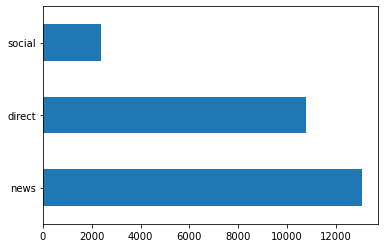

In [42]:
df['genre'].value_counts().plot(kind='barh');

In [70]:
sub_cols=['related', 'request', 'offer',
       'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
       'security', 'military', 'child_alone', 'water', 'food', 'shelter',
       'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report']

sub_cols.sort()
print(sub_cols)

['aid_centers', 'aid_related', 'buildings', 'child_alone', 'clothing', 'cold', 'death', 'direct_report', 'earthquake', 'electricity', 'fire', 'floods', 'food', 'hospitals', 'infrastructure_related', 'medical_help', 'medical_products', 'military', 'missing_people', 'money', 'offer', 'other_aid', 'other_infrastructure', 'other_weather', 'refugees', 'related', 'request', 'search_and_rescue', 'security', 'shelter', 'shops', 'storm', 'tools', 'transport', 'water', 'weather_related']


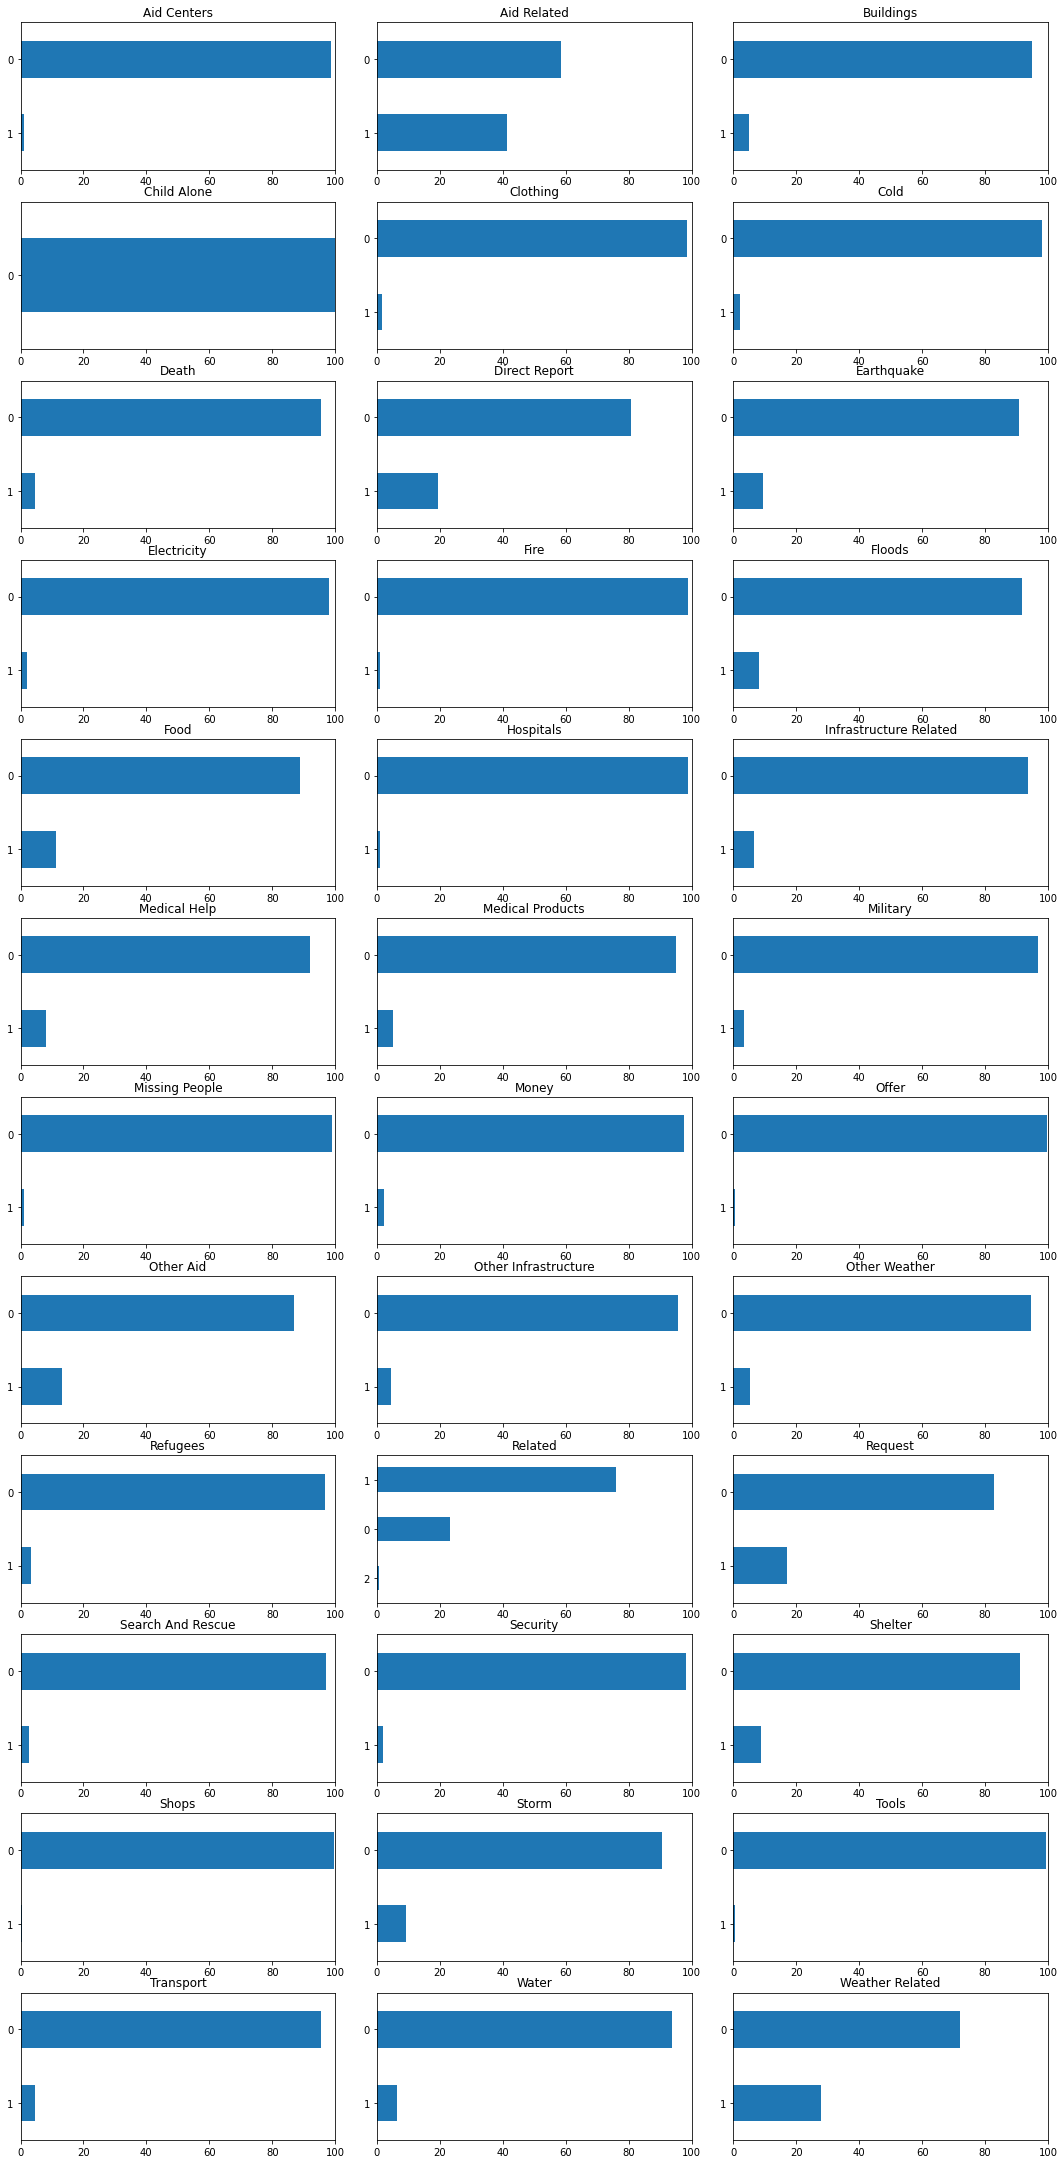

In [120]:
import math
import matplotlib.pyplot as plt

i, j = 0, 0
PLOTS_PER_ROW = 3
fig, axs = plt.subplots(math.ceil(len(sub_cols) / PLOTS_PER_ROW), PLOTS_PER_ROW, figsize=(15, 30))
fig.tight_layout()
for col in sub_cols:
    #axs[i][j].scatter(df['target_col'], df[col], s=3)
    (df[col].value_counts(normalize=True)*100).sort_values().plot(kind='barh', ax=axs[i][j])
    axs[i][j].set_title(col.replace('_', ' ').title())
    axs[i][j].set_xlim(xmin=0, xmax=100)
    j += 1
    if j % PLOTS_PER_ROW == 0:
        i += 1
        j = 0
plt.show()

In [116]:
(df['related'].value_counts(normalize=True)*100).sort_values()

2     0.717119
0    23.352151
1    75.930729
Name: related, dtype: float64